In [1]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from keras import layers, models, regularizers

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.layers import TimeDistributed

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import os
import winsound
from sklearn.preprocessing import LabelEncoder
import datetime as dt

os.chdir('../scripts')
from functions import impute_immediate_mean
os.chdir('../notebooks')


In [2]:
# Set up alarm for notification of model completion
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

## Read in Data

In [19]:
df_raw =pd.read_csv('../data/df_clean.csv', index_col=0, parse_dates=True)
TSO_preds = df_raw.price_forecast_tomorrow

In [2]:
# Read in data
df = pd.read_csv('../data/df_clean.csv', index_col=0, parse_dates=True)

## Continuous

In [5]:
#df.drop(columns='diff', inplace=True)

#continuous = df.select_dtypes(exclude='object').drop(columns=['price_tomorrow']).columns
continuous = df.select_dtypes(exclude='object').drop(columns=['price_tomorrow', 'price_forecast_tomorrow']).columns

# Get rid of negatives
time = dt.datetime(2021,3,23,22)
df.loc[time, 'dew_point_bilbao'] = impute_immediate_mean(df['dew_point_bilbao'], time)

# Rescale data [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))
df[continuous] = scaler.fit_transform(df[continuous])

## Categoricals

In [6]:
# Get Categorical columns
categorical = df.select_dtypes(include='object').columns

# Instationate LabelEncoder, fit and transform on wind_direction cols
wind_dir_coder = LabelEncoder()
wind_dir_coder.fit(df['wind_madrid'])
for col in ['wind_madrid', 'wind_seville', 'wind_barcelona', 'wind_bilbao', 'wind_valencia']:
    df[col] = wind_dir_coder.transform(df[col])
    

# Stack condition columns into single col
stacked_conditions = df.filter(regex='condition').stack()

# Instantiate Label encoder, fit and transform on condition cols
condition_coder = LabelEncoder()
condition_coder.fit(stacked_conditions)
for col in df.filter(regex='condition').columns:
    df[col] = condition_coder.transform(df[col])

# Rescale data [-1,1]
df[categorical] = scaler.fit_transform(df[categorical])

## Split Data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price_tomorrow'), df['price_tomorrow'], test_size=.3,
                                                    random_state=17)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=17)

## Neural Network

In [7]:
from sklearn.metrics import mean_absolute_percentage_error

In [8]:
import keras.backend as K
def sMAPE(y_true, y_pred):
    return 100 * K.mean(abs(y_pred - y_true)/((abs(y_true)+abs(y_pred))/2))

In [9]:
def SMAPE(y_true, y_pred):
    return 100/(len(y_true)) * (abs(y_pred - y_true)/((abs(y_true)+abs(y_pred))/2)).sum()

In [211]:
metric = sMAPE
metric.name = 'sMAPE'
print('val_'+metric.name)

val_sMAPE


In [10]:
def split_data(data, val_year):

    # Divide dataset into training and validation
    X_train = data.loc[:str(val_year-1)].drop(columns='price_tomorrow')
    y_train = data.loc[:str(val_year-1), 'price_tomorrow']
    X_val = data.loc[str(val_year)].drop(columns='price_tomorrow')
    y_val = data.loc[str(val_year), 'price_tomorrow']
    return X_train, y_train, X_val, y_val

def compile_fit(nn, X_train, y_train, validation,
                patience=10,
                metric=sMAPE,
                #metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE'),
                loss = tf.keras.metrics.mean_absolute_error,
                batch_size = None):
    
    # Create early stopping point
    metric.name='sMAPE'
    callback = keras.callbacks.EarlyStopping(
        patience=patience,
        monitor='val_'+metric.name,
        mode='min',
        restore_best_weights=True
    )
    # Compile the model
    nn.compile(
        loss=loss, 
        optimizer=keras.optimizers.Adam(),
        metrics=metric
    )
    
    # Fit the model
    history = nn.fit(
        x = X_train,
        y = y_train,
        batch_size=batch_size,
        epochs = 200,
        callbacks=[callback],
        validation_data=validation
    )
    return nn

In [15]:
# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(62, activation='relu', input_shape=(shape,)))
nn.add(layers.Dense(239, activation='relu'))
nn.add(layers.Dense(162, activation='relu'))
nn.add(layers.Dense(1, activation='relu'))


In [14]:
shape = len(X_train.columns)

In [16]:
X_train, y_train, X_val, y_val = split_data(df, 2020)

bl = compile_fit(nn, X_train, y_train, (X_val, y_val),
                patience=10,
                loss = tf.keras.metrics.mean_absolute_error)
preds = bl.predict(X_val).flatten()
r2 = (np.corrcoef(y_val, preds)**2)[0][1]
print('r2:', r2)
print('mape:', mean_absolute_percentage_error(y_val, preds)*100)
print('smape:', SMAPE(y_val, preds))
loss, sMAPE_val = bl.evaluate(X_val, y_val, verbose=0)
print('smape:', sMAPE_val)

Epoch 1/200
1370/1370 [==============================] - 2s 1ms/step - loss: 2.0992 - sMAPE: 4.3128 - val_loss: 1.7284 - val_sMAPE: 5.0428
Epoch 2/200
1370/1370 [==============================] - 2s 1ms/step - loss: 1.5216 - sMAPE: 2.9144 - val_loss: 1.9358 - val_sMAPE: 5.4734
Epoch 3/200
1370/1370 [==============================] - 2s 1ms/step - loss: 1.4467 - sMAPE: 2.7597 - val_loss: 1.7417 - val_sMAPE: 5.1736
Epoch 4/200
1370/1370 [==============================] - 2s 1ms/step - loss: 1.3971 - sMAPE: 2.6582 - val_loss: 1.5125 - val_sMAPE: 4.5392
Epoch 5/200
1370/1370 [==============================] - 2s 1ms/step - loss: 1.3742 - sMAPE: 2.6165 - val_loss: 1.7475 - val_sMAPE: 5.2833
Epoch 6/200
1370/1370 [==============================] - 2s 1ms/step - loss: 1.3565 - sMAPE: 2.5725 - val_loss: 1.9629 - val_sMAPE: 5.8024
Epoch 7/200
1370/1370 [==============================] - 2s 1ms/step - loss: 1.3170 - sMAPE: 2.5025 - val_loss: 1.5946 - val_sMAPE: 4.8130
Epoch 8/200
1370/1370 [====

In [44]:
# Instantiate model and build layers
nn_final = models.Sequential()
nn_final.add(layers.Dense(62, activation='relu', input_shape=(shape,)))
nn_final.add(layers.Dense(239, activation='relu'))
nn_final.add(layers.Dense(162, activation='relu'))
nn_final.add(layers.Dense(1, activation='relu'))


In [45]:
X_train, y_train, X_val, y_val = split_data(df, 2021)

bl_final = compile_fit(nn_final, X_train, y_train, (X_val, y_val),
                patience=10,
                loss = tf.keras.metrics.mean_absolute_error)
preds = bl_final.predict(X_val).flatten()
r2 = (np.corrcoef(y_val, preds)**2)[0][1]
print('r2:', r2)
print('mape:', mean_absolute_percentage_error(y_val, preds)*100)
print('smape:', SMAPE(y_val, preds))
loss, sMAPE_val = bl_final.evaluate(X_val, y_val, verbose=0)
print('smape:', sMAPE_val)

Epoch 1/200
1644/1644 [==============================] - 3s 1ms/step - loss: 1.9733 - sMAPE: 4.2737 - val_loss: 3.5257 - val_sMAPE: 3.9302
Epoch 2/200
1644/1644 [==============================] - 2s 1ms/step - loss: 1.5054 - sMAPE: 3.0898 - val_loss: 2.5294 - val_sMAPE: 3.1163
Epoch 3/200
1644/1644 [==============================] - 2s 1ms/step - loss: 1.4663 - sMAPE: 3.0000 - val_loss: 2.7105 - val_sMAPE: 3.2777
Epoch 4/200
1644/1644 [==============================] - 3s 2ms/step - loss: 1.4028 - sMAPE: 2.8682 - val_loss: 2.4926 - val_sMAPE: 3.0372
Epoch 5/200
1644/1644 [==============================] - 3s 2ms/step - loss: 1.3379 - sMAPE: 2.7306 - val_loss: 2.8074 - val_sMAPE: 3.3143
Epoch 6/200
1644/1644 [==============================] - 2s 1ms/step - loss: 1.3100 - sMAPE: 2.6720 - val_loss: 2.6923 - val_sMAPE: 3.1800
Epoch 7/200
1644/1644 [==============================] - 2s 1ms/step - loss: 1.2757 - sMAPE: 2.6006 - val_loss: 2.9182 - val_sMAPE: 3.5041
Epoch 8/200
1644/1644 [====

In [20]:
print('r2:', (np.corrcoef(y_val,TSO_preds.loc['2020'])**2)[0][1])
print('mape:', mean_absolute_percentage_error(y_val,TSO_preds.loc['2020'])*100)
print('smape:', SMAPE(y_val,TSO_preds.loc['2020']))

r2: 0.9714777867123521
mape: 14.959628546355278
smape: 16.918003049222687


In [18]:
X_train, y_train, X_test, y_test = split_data(df, 2021)
preds = bl.predict(X_test).flatten()
r2 = (np.corrcoef(y_test, preds)**2)[0][1]
print('r2:', r2)
print('mape:', mean_absolute_percentage_error(y_test, preds)*100)
print('smape:', SMAPE(y_test, preds))
resid_forecast = preds - y_test
resid_forecast

r2: 0.9974031129868238
mape: 3.210796692591586
smape: 3.334922035726982


2021-01-01 00:00:00    -0.131090
2021-01-01 01:00:00    -2.204759
2021-01-01 02:00:00    -1.673647
2021-01-01 03:00:00    -1.716557
2021-01-01 04:00:00    -2.175416
                         ...    
2021-12-30 19:00:00    -7.747296
2021-12-30 20:00:00    -5.384048
2021-12-30 21:00:00    -9.977943
2021-12-30 22:00:00   -13.360194
2021-12-30 23:00:00   -17.658956
Name: price_tomorrow, Length: 8736, dtype: float64

In [9]:
# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(239, activation='relu', input_shape=(X_train.shape[1],)))
nn.add(layers.Dense(162, activation='relu'))
nn.add(layers.Dense(1, activation='relu'))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
nn.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(learning_rate=.0001),
           metrics=metric)

# Fit the model
history = nn.fit(x= X_train,
                 y=y_train,
                 batch_size=128,
                 epochs = 100,
                 callbacks=[callback],
                 validation_data=(X_val, y_val),
)

preds_train = nn.predict(X_train).flatten()
preds_val = nn.predict(X_val).flatten()

print('r2:',r2_score(y_train, preds_train))
print('r2:',(np.corrcoef(y_train, preds_train)**2)[0][1])

print('val r2:',r2_score(y_val, preds_val))
print('val r2:',(np.corrcoef(y_val, preds_val)**2)[0][1])

Epoch 1/100
334/334 [==============================] - 1s 2ms/step - loss: 42.3649 - MAPE: 83.3904 - val_loss: 24.8675 - val_MAPE: 111.7421
Epoch 2/100
334/334 [==============================] - 1s 2ms/step - loss: 24.3124 - MAPE: 68.8397 - val_loss: 23.3587 - val_MAPE: 100.0323
Epoch 3/100
334/334 [==============================] - 1s 2ms/step - loss: 23.2809 - MAPE: 62.0716 - val_loss: 22.6162 - val_MAPE: 96.2855
Epoch 4/100
334/334 [==============================] - 1s 2ms/step - loss: 22.5349 - MAPE: 60.1233 - val_loss: 21.8751 - val_MAPE: 94.0755
Epoch 5/100
334/334 [==============================] - 1s 2ms/step - loss: 21.7326 - MAPE: 58.6938 - val_loss: 21.1528 - val_MAPE: 95.9708
Epoch 6/100
334/334 [==============================] - 1s 2ms/step - loss: 20.7999 - MAPE: 56.7986 - val_loss: 20.1292 - val_MAPE: 94.3731
Epoch 7/100
334/334 [==============================] - 1s 2ms/step - loss: 19.6020 - MAPE: 55.6993 - val_loss: 18.8427 - val_MAPE: 95.4855
Epoch 8/100
334/334 [====

In [ ]:
X_train_, y_train, X_val, y_val = split_data(df, 2021)

In [ ]:
nn.predict(df)

In [42]:
# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(239, activation='relu', input_shape=(X_train.shape[1],),
                    kernel_regularizer=regularizers.L1(.0001)))
nn.add(layers.Dense(162, activation='relu', kernel_regularizer=regularizers.L1(.0001)))
nn.add(layers.Dense(1, activation='relu'))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
nn.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(learning_rate=.0001),
           metrics=metric)

# Fit the model
history = nn.fit(x= X_train,
                 y=y_train,
                 batch_size=256,
                 epochs = 100,
                 callbacks=[callback],
                 validation_data=(X_val, y_val),
)

preds_train = nn.predict(X_train).flatten()
preds_val = nn.predict(X_val).flatten()

print('r2:',r2_score(y_train, preds_train))
print('r2:',(np.corrcoef(y_train, preds_train)**2)[0][1])

print('val r2:',r2_score(y_val, preds_val))
print('val r2:',(np.corrcoef(y_val, preds_val)**2)[0][1])

Epoch 1/100
167/167 [==============================] - 1s 4ms/step - loss: 40.7536 - MAPE: 82.2737 - val_loss: 29.4587 - val_MAPE: 112.3087
Epoch 2/100
167/167 [==============================] - 0s 3ms/step - loss: 27.4505 - MAPE: 78.2185 - val_loss: 25.6727 - val_MAPE: 95.6277
Epoch 3/100
167/167 [==============================] - 0s 3ms/step - loss: 24.9472 - MAPE: 65.1849 - val_loss: 23.9091 - val_MAPE: 81.0519
Epoch 4/100
167/167 [==============================] - 1s 3ms/step - loss: 23.1896 - MAPE: 55.6207 - val_loss: 22.2045 - val_MAPE: 68.1717
Epoch 5/100
167/167 [==============================] - 0s 3ms/step - loss: 21.1731 - MAPE: 47.3178 - val_loss: 20.1566 - val_MAPE: 54.0342
Epoch 6/100
167/167 [==============================] - 0s 3ms/step - loss: 18.9979 - MAPE: 40.0940 - val_loss: 18.0588 - val_MAPE: 41.6691
Epoch 7/100
167/167 [==============================] - 0s 3ms/step - loss: 16.8930 - MAPE: 35.7444 - val_loss: 16.0439 - val_MAPE: 28.6478
Epoch 8/100
167/167 [=====

## Neural Network - 24 Hour Prediction 
Two hidden layers
### Data Preparation

In [21]:
def to_supervised(train, n_input, n_out=7, stride=1):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :-1])
            y.append(data[in_end:out_end, -1])
        # move along one time step
        in_start += stride
    return np.array(X), np.array(y)

In [30]:
train = df.loc[:'2019'].drop(columns='price_tomorrow')
val = df.loc['2020'].drop(columns='price_tomorrow')

train['price_tomorrow'] = df.loc[:'2019', 'price_tomorrow']
val['price_tomorrow'] = df.loc['2020', 'price_tomorrow']

train = np.array(np.split(train, len(train)/24))
val = np.array(np.split(val, len(val)/24))
print(train.shape)
print(val.shape)


X_train, y_train = to_supervised(train, n_input=24, n_out=24, stride=24)
X_val, y_val = to_supervised(val, n_input=24, n_out=24, stride=24)
input_shape=(X_train.shape[1], X_train.shape[2])

(1826, 24, 62)
(366, 24, 62)


In [31]:
# Instantiate model and build layers
bm = models.Sequential()
bm.add(layers.Dense(62, activation='relu', input_shape=input_shape))
bm.add(layers.Dense(239, activation='relu'))
bm.add(layers.Dense(162, activation='relu'))
bm.add(TimeDistributed(layers.Dense(1)))

Notes:

* <u>monitor_metric & metric (MAPE)</u>:  chosen because sMAPE not available. Chance to hard code sMAPE and implement?
* <u>patience (10)</u>: chosen to prevent reaching local minimum
* <u>loss function (mean_absolute_error)</u>: chosen because as the electricity prices have large spikes, the Euclidean norm would put too much importance on the spiky prices
* 

In [32]:
# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
bm.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(),
           metrics=metric)

# Fit the model
history = bm.fit(x= X_train,
                 y=y_train,
                 epochs = 100,
                 callbacks=[callback],
                 batch_size=32,
                 validation_data=(X_val, y_val),
)

preds_train = bm.predict(X_train).flatten()
preds_val = bm.predict(X_val).flatten()


print('train r2:',r2_score(y_train.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val.flatten(), preds_val)**2)[0][1])

Epoch 1/100
58/58 [==============================] - 1s 6ms/step - loss: 12.8354 - MAPE: 23.8156 - val_loss: 6.6339 - val_MAPE: 20.9957
Epoch 2/100
58/58 [==============================] - 0s 4ms/step - loss: 6.2299 - MAPE: 12.9851 - val_loss: 6.3519 - val_MAPE: 20.7919
Epoch 3/100
58/58 [==============================] - 0s 4ms/step - loss: 5.9734 - MAPE: 12.6865 - val_loss: 7.3727 - val_MAPE: 24.7458
Epoch 4/100
58/58 [==============================] - 0s 5ms/step - loss: 5.9424 - MAPE: 12.5946 - val_loss: 8.1275 - val_MAPE: 27.1244
Epoch 5/100
58/58 [==============================] - 0s 4ms/step - loss: 5.9886 - MAPE: 12.7219 - val_loss: 7.2862 - val_MAPE: 24.4366
Epoch 6/100
58/58 [==============================] - 0s 4ms/step - loss: 5.7854 - MAPE: 12.3688 - val_loss: 5.4870 - val_MAPE: 18.0086
Epoch 7/100
58/58 [==============================] - 0s 4ms/step - loss: 5.7725 - MAPE: 12.2448 - val_loss: 6.0984 - val_MAPE: 20.8754
Epoch 8/100
58/58 [==============================] - 0

In [38]:
# Instantiate model and build layers
bm = models.Sequential()
bm.add(layers.Dense(239, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1(0.9)))
bm.add(layers.Dropout(.9))
bm.add(layers.Dense(162, activation='relu', kernel_regularizer=regularizers.l1(0.9)))
bm.add(layers.Dropout(.9))
bm.add(TimeDistributed(layers.Dense(1)))

In [39]:
# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
bm.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(),
           metrics=metric)

# Fit the model
history = bm.fit(x= X_train,
                 y=y_train,
                 epochs = 200,
                 callbacks=[callback],
                 batch_size=512,
                 validation_data=(X_val, y_val),
)

preds_train = bm.predict(X_train).flatten()
preds_val = bm.predict(X_val).flatten()

print('train r2:',r2_score(y_train.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val.flatten(), preds_val)**2)[0][1])

Epoch 1/200
4/4 [==============================] - 1s 123ms/step - loss: 3070.5112 - MAPE: 101.8340 - val_loss: 2922.1626 - val_MAPE: 101.8104
Epoch 2/200
4/4 [==============================] - 0s 93ms/step - loss: 2883.5691 - MAPE: 101.3586 - val_loss: 2739.7991 - val_MAPE: 101.1662
Epoch 3/200
4/4 [==============================] - 0s 84ms/step - loss: 2703.2878 - MAPE: 100.7100 - val_loss: 2563.8469 - val_MAPE: 100.5940
Epoch 4/200
4/4 [==============================] - 0s 105ms/step - loss: 2529.2197 - MAPE: 100.2305 - val_loss: 2394.1724 - val_MAPE: 100.0971
Epoch 5/200
4/4 [==============================] - 0s 88ms/step - loss: 2361.3186 - MAPE: 99.6174 - val_loss: 2230.2959 - val_MAPE: 99.6700
Epoch 6/200
4/4 [==============================] - 0s 99ms/step - loss: 2199.3940 - MAPE: 99.2076 - val_loss: 2072.3784 - val_MAPE: 99.3002
Epoch 7/200
4/4 [==============================] - 0s 85ms/step - loss: 2043.2935 - MAPE: 98.9438 - val_loss: 1920.2661 - val_MAPE: 98.9757
Epoch 8/20

In [78]:
# Instantiate model and build layers
bm = models.Sequential()
bm.add(layers.Dense(239, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1(0)))
bm.add(layers.Dropout(.9))
bm.add(layers.Dense(162, activation='relu', kernel_regularizer=regularizers.l1(0)))
bm.add(layers.Dropout(.9))
bm.add(TimeDistributed(layers.Dense(1)))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
bm.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(),
           metrics=metric)

# Fit the model
history = bm.fit(x= X_train,
                 y=y_train,
                 epochs = 100,
                 callbacks=[callback],
                 batch_size=128,
                 validation_data=(X_val, y_val),
)

preds_train = bm.predict(X_train).flatten()
preds_val = bm.predict(X_val).flatten()

print('train r2:',r2_score(y_train.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val.flatten(), preds_val)**2)[0][1])

Epoch 1/100
15/15 [==============================] - 1s 36ms/step - loss: 45.4839 - MAPE: 91.9167 - val_loss: 14.1024 - val_MAPE: 66.8014
Epoch 2/100
15/15 [==============================] - 0s 29ms/step - loss: 33.7040 - MAPE: 79.5775 - val_loss: 11.1353 - val_MAPE: 52.1070
Epoch 3/100
15/15 [==============================] - 0s 27ms/step - loss: 29.3823 - MAPE: 66.4293 - val_loss: 10.0158 - val_MAPE: 47.2930
Epoch 4/100
15/15 [==============================] - 0s 27ms/step - loss: 27.3341 - MAPE: 62.4996 - val_loss: 9.8122 - val_MAPE: 45.6371
Epoch 5/100
15/15 [==============================] - 0s 28ms/step - loss: 25.9432 - MAPE: 55.5520 - val_loss: 9.7036 - val_MAPE: 45.2370
Epoch 6/100
15/15 [==============================] - 0s 28ms/step - loss: 25.4551 - MAPE: 56.4819 - val_loss: 9.4428 - val_MAPE: 42.3645
Epoch 7/100
15/15 [==============================] - 0s 28ms/step - loss: 24.9479 - MAPE: 53.2063 - val_loss: 9.4181 - val_MAPE: 42.3927
Epoch 8/100
15/15 [===================

In [81]:
# Instantiate model and build layers
bm = models.Sequential()
bm.add(layers.Dense(239, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1(0.001)))
bm.add(layers.Dropout(.9))
bm.add(layers.Dense(162, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
bm.add(layers.Dropout(.9))
bm.add(TimeDistributed(layers.Dense(1)))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
bm.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(),
           metrics=metric)

# Fit the model
history = bm.fit(x= X_train,
                 y=y_train,
                 epochs = 100,
                 callbacks=[callback],
                 batch_size=128,
                 validation_data=(X_val, y_val),
)

preds_train = bm.predict(X_train).flatten()
preds_val = bm.predict(X_val).flatten()

print('train r2:',r2_score(y_train.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val.flatten(), preds_val)**2)[0][1])

Epoch 1/100
15/15 [==============================] - 1s 39ms/step - loss: 46.8585 - MAPE: 90.4892 - val_loss: 17.5185 - val_MAPE: 67.1698
Epoch 2/100
15/15 [==============================] - 0s 31ms/step - loss: 36.7941 - MAPE: 79.6642 - val_loss: 13.9950 - val_MAPE: 47.4856
Epoch 3/100
15/15 [==============================] - 0s 29ms/step - loss: 32.5062 - MAPE: 66.7438 - val_loss: 13.3872 - val_MAPE: 48.3413
Epoch 4/100
15/15 [==============================] - 0s 29ms/step - loss: 30.4398 - MAPE: 60.3333 - val_loss: 12.8435 - val_MAPE: 44.3023
Epoch 5/100
15/15 [==============================] - 0s 29ms/step - loss: 28.9885 - MAPE: 53.8950 - val_loss: 12.7383 - val_MAPE: 45.2990
Epoch 6/100
15/15 [==============================] - 0s 29ms/step - loss: 28.0770 - MAPE: 54.0073 - val_loss: 12.3631 - val_MAPE: 42.5779
Epoch 7/100
15/15 [==============================] - 0s 31ms/step - loss: 27.3943 - MAPE: 52.5591 - val_loss: 12.2777 - val_MAPE: 43.1760
Epoch 8/100
15/15 [===============

### Limit Price Spikes
Limit price spikes to +- 3*STD

<AxesSubplot:>

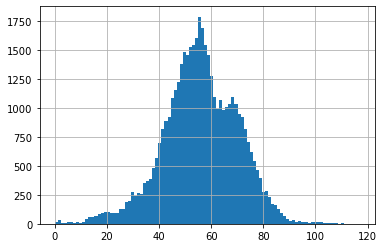

In [86]:
df.loc[:'2019', 'price_tomorrow'].hist(bins=100)

In [33]:
# Get train data, move price column to the end of set
train = df.loc[:'2019'].drop(columns='price_tomorrow')
train['price_tomorrow'] = df.loc[:'2019', 'price_tomorrow']

# Get price_tomorrow std, mean
price_std = df.loc[:'2019', 'price_tomorrow'].std()
price_mean = df.loc[:'2019', 'price_tomorrow'].mean()

# Copy price data and trim
train_trimmed = train.copy()
train_trimmed.loc[train_trimmed.price_tomorrow>(price_mean + price_std*3), 'price_tomorrow'] = price_mean + price_std*3

# Prep trimmed set for modeling
train_trimmed = np.array(np.split(train_trimmed, len(train_trimmed)/24))
X_train_trimmed, y_train_trimmed = to_supervised(train_trimmed, n_input=24, n_out=24, stride=24)
input_shape=(X_train_trimmed.shape[1], X_train_trimmed.shape[2])

In [37]:
# Instantiate model and build layers
bm_1 = models.Sequential()
bm_1.add(layers.Dense(62, activation='relu', input_shape=input_shape))
bm_1.add(layers.Dense(239, activation='relu'))
bm_1.add(layers.Dense(162, activation='relu'))
bm_1.add(TimeDistributed(layers.Dense(1)))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
bm_1.compile(loss=tf.keras.metrics.mean_absolute_error, 
           optimizer=keras.optimizers.Adam(),
           metrics=metric)

# Fit the model
history = bm_1.fit(x= X_train_trimmed,
                 y=y_train_trimmed,
                 epochs = 100,
                 callbacks=[callback],
                 batch_size=128,
                 validation_data=(X_val, y_val),
)

preds_train = bm_1.predict(X_train_trimmed).flatten()
preds_val = bm_1.predict(X_val).flatten()

print('train r2:',r2_score(y_train_trimmed.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val.flatten(), preds_val)**2)[0][1])

Epoch 1/100
15/15 [==============================] - 1s 19ms/step - loss: 27.5423 - MAPE: 48.7608 - val_loss: 11.3260 - val_MAPE: 32.1205
Epoch 2/100
15/15 [==============================] - 0s 11ms/step - loss: 9.4534 - MAPE: 18.0859 - val_loss: 5.8631 - val_MAPE: 17.3613
Epoch 3/100
15/15 [==============================] - 0s 10ms/step - loss: 6.9641 - MAPE: 13.8306 - val_loss: 5.6631 - val_MAPE: 16.9238
Epoch 4/100
15/15 [==============================] - 0s 11ms/step - loss: 6.3103 - MAPE: 12.8144 - val_loss: 6.1048 - val_MAPE: 19.4528
Epoch 5/100
15/15 [==============================] - 0s 11ms/step - loss: 6.0803 - MAPE: 12.8012 - val_loss: 6.6318 - val_MAPE: 22.0523
Epoch 6/100
15/15 [==============================] - 0s 10ms/step - loss: 5.9934 - MAPE: 12.6876 - val_loss: 6.1971 - val_MAPE: 20.4445
Epoch 7/100
15/15 [==============================] - 0s 11ms/step - loss: 5.9179 - MAPE: 12.5849 - val_loss: 6.8428 - val_MAPE: 22.7620
Epoch 8/100
15/15 [===========================

Trimming the training response variable did not improve model performance much.

## LSTM - DNN
### DNN

In [38]:
# Get columns representing future information 
DNN_cols = df.filter(regex='forecast').columns

train = df.loc[:'2019', DNN_cols].copy()
val = df.loc['2020', DNN_cols].copy()

train['price_tomorrow'] = df.loc[:'2019', 'price_tomorrow']
val['price_tomorrow'] = df.loc['2020', 'price_tomorrow']

train = np.array(np.split(train, len(train)/24))
val = np.array(np.split(val, len(val)/24))
print(train.shape)
print(val.shape)


X_train, y_train = to_supervised(train, n_input=24, n_out=24, stride=24)
X_val, y_val = to_supervised(val, n_input=24, n_out=24, stride=24)
input_shape=(X_train.shape[1], X_train.shape[2])
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1826, 24, 7)
(366, 24, 7)
(1825, 24, 6) (1825, 24)
(365, 24, 6) (365, 24)


In [ ]:
# Instantiate model and build layers
bm_1 = models.Sequential()
bm_1.add(layers.Dense(62, activation='relu', input_shape=input_shape))
bm_1.add(layers.Dense(239, activation='relu'))
bm_1.add(layers.Dense(162, activation='relu'))
bm_1.add(TimeDistributed(layers.Dense(1)))

In [40]:
dnn = models.Sequential()
dnn.add(layers.Dense(62, activation='relu', input_shape=input_shape))
dnn.add(layers.Dense(239, activation='relu'))
dnn.add(layers.Dense(162, activation='relu'))
dnn.add(TimeDistributed(layers.Dense(1)))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
dnn.compile(loss=tf.keras.metrics.mean_absolute_error, 
            optimizer=keras.optimizers.Adam(),
            metrics=metric)

# Fit the model
history = dnn.fit(x= X_train,
                  y=y_train,
                  epochs = 100,
                  callbacks=[callback],
                  batch_size=128,
                  validation_data=(X_val, y_val),
)

preds_train = dnn.predict(X_train).flatten()
preds_val = dnn.predict(X_val).flatten()

print('train r2:',r2_score(y_train.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val.flatten(), preds_val)**2)[0][1])

Epoch 1/100
15/15 [==============================] - 1s 22ms/step - loss: 31.1012 - MAPE: 54.8837 - val_loss: 7.6221 - val_MAPE: 22.0542
Epoch 2/100
15/15 [==============================] - 0s 15ms/step - loss: 9.5633 - MAPE: 18.6024 - val_loss: 6.4179 - val_MAPE: 18.1986
Epoch 3/100
15/15 [==============================] - 0s 15ms/step - loss: 6.9690 - MAPE: 13.9584 - val_loss: 6.0370 - val_MAPE: 17.4881
Epoch 4/100
15/15 [==============================] - 0s 15ms/step - loss: 6.7030 - MAPE: 13.4970 - val_loss: 5.9364 - val_MAPE: 17.4142
Epoch 5/100
15/15 [==============================] - 0s 14ms/step - loss: 6.6260 - MAPE: 13.3519 - val_loss: 5.8679 - val_MAPE: 17.1270
Epoch 6/100
15/15 [==============================] - 0s 15ms/step - loss: 6.5688 - MAPE: 13.1972 - val_loss: 5.7908 - val_MAPE: 16.9660
Epoch 7/100
15/15 [==============================] - 0s 18ms/step - loss: 6.4767 - MAPE: 13.0076 - val_loss: 5.6648 - val_MAPE: 16.5560
Epoch 8/100
15/15 [============================

### LSTM

In [116]:
# Get columns representing past information 
LSTM_cols = list(set(df.columns) - set(DNN_cols))

train_LSTM = df.loc[:'2019', LSTM_cols].copy()
val_LSTM = df.loc['2020', LSTM_cols].copy()

train_LSTM['price_tomorrow'] = df.loc[:'2019', 'price_tomorrow']
val_LSTM['price_tomorrow'] = df.loc['2020', 'price_tomorrow']

train_LSTM = np.array(np.split(train_LSTM, len(train_LSTM)/24))
val_LSTM = np.array(np.split(val_LSTM, len(val_LSTM)/24))
print(train_LSTM.shape)
print(val_LSTM.shape)


X_train_LSTM, y_train_LSTM = to_supervised(train, n_input=24, n_out=24, stride=24)
X_val_LSTM, y_val_LSTM = to_supervised(val, n_input=24, n_out=24, stride=24)
input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])
print(X_train_LSTM.shape, y_train_LSTM.shape)
print(X_val_LSTM.shape, y_val_LSTM.shape)

(1825, 24, 57)
(366, 24, 57)
(1824, 24, 6) (1824, 24)
(365, 24, 6) (365, 24)


In [118]:
y_train_LSTM.shape[1]*7

168

In [107]:
from keras.layers import RepeatVector

In [165]:
lstm = keras.Sequential()
lstm.add(layers.LSTM(83, activation='tanh', input_shape=input_shape))
lstm.add(RepeatVector(y_train_LSTM.shape[1]))
lstm.add(layers.Dense(184, activation='relu', kernel_regularizer=regularizers.l1(0.1)))
lstm.add(TimeDistributed(layers.Dense(1)))

# Loss Metric to optimize
metric = tf.keras.metrics.MeanAbsolutePercentageError(name='MAPE')

# Create early stopping point
callback = keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_'+metric.name,
    mode='min',
    restore_best_weights=True
)


# Compile the model
dnn.compile(loss=tf.keras.metrics.mean_absolute_error, 
            optimizer=keras.optimizers.Adam(),
            metrics=metric)

# Fit the model
history = dnn.fit(x= X_train_LSTM,
                  y=y_train_LSTM,
                  epochs = 100,
                  callbacks=[callback],
                  batch_size=128,
                  validation_data=(X_val_LSTM, y_val_LSTM),
)

preds_train = dnn.predict(X_train_LSTM).flatten()
preds_val = dnn.predict(X_val_LSTM).flatten()

print('train r2:',r2_score(y_train_LSTM.flatten(), preds_train))
print('train r2:',(np.corrcoef(y_train_LSTM.flatten(), preds_train)**2)[0][1])

print('val r2:',r2_score(y_val_LSTM.flatten(), preds_val))
print('val r2:',(np.corrcoef(y_val_LSTM.flatten(), preds_val)**2)[0][1])

Epoch 1/100
15/15 [==============================] - 1s 38ms/step - loss: 26.6459 - MAPE: 48.2963 - val_loss: 14.2966 - val_MAPE: 51.7783
Epoch 2/100
15/15 [==============================] - 0s 28ms/step - loss: 25.3086 - MAPE: 45.2933 - val_loss: 13.4928 - val_MAPE: 53.2092
Epoch 3/100
15/15 [==============================] - 0s 28ms/step - loss: 24.1907 - MAPE: 46.2159 - val_loss: 13.4061 - val_MAPE: 55.4275
Epoch 4/100
15/15 [==============================] - 0s 29ms/step - loss: 23.3549 - MAPE: 46.3062 - val_loss: 13.2973 - val_MAPE: 57.4276
Epoch 5/100
15/15 [==============================] - 0s 28ms/step - loss: 22.4916 - MAPE: 46.2195 - val_loss: 13.4286 - val_MAPE: 59.3083
Epoch 6/100
15/15 [==============================] - 0s 28ms/step - loss: 21.9316 - MAPE: 45.3119 - val_loss: 13.7680 - val_MAPE: 61.9331
Epoch 7/100
15/15 [==============================] - 0s 29ms/step - loss: 21.4020 - MAPE: 44.5079 - val_loss: 13.7720 - val_MAPE: 63.9574
Epoch 8/100
15/15 [===============

In [125]:
np.corrcoef(df['price_forecast_tomorrow'].values, df.price_tomorrow)**2

array([[1.        , 0.48064142],
       [0.48064142, 1.        ]])

### Ensemble LSTM-DNN Model

## GRU - DNN

## CNN